In [7]:
# this code is written by Changyi Yang used for DS Discovery program

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [2]:
torch. __version__

'1.13.0+cpu'

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/Shareddrives/PebbleReactorProject/Data

In [4]:
# define the dataset classes
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class ReactorData(Dataset):
    def __init__(self,file_name, sequence_length, start_percent = 0, end_percent = 1):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        # print(data.shape)
        
        self.labels = data.iloc[:, -1:]
        self.data = data.iloc[:, 1:-1] # skip the first time column
        
        mm = MinMaxScaler()
        ss = StandardScaler()


        self.data = ss.fit_transform(self.data)
        self.labels = mm.fit_transform(self.labels) 
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()

        

In [20]:
# load the data
sequence_length = 20

training_data = ReactorData('data_PBMR_400.csv', sequence_length= sequence_length, start_percent= 0, end_percent= 0.75)
testing_data = ReactorData('data_PBMR_400.csv', sequence_length= sequence_length, start_percent= 0.75, end_percent= 1)


(175, 40040)
(175,)


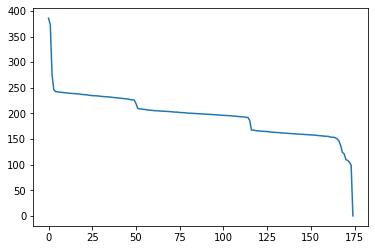

In [21]:
# do some data analysis for the PCA part

# for the full matrix
data= training_data.data

# do the svd
U, S, VT = np.linalg.svd(data, full_matrices= False)

print(data.shape)
print(S.shape)

plt.plot(S)




[236.56746254 204.77361867 203.88242949 202.37473348 202.03902337
 201.13506055 200.99913909 200.72867352 199.78427334 199.71470868
 199.13471981 198.72809792 198.54151216 197.98647176 197.86658453
 197.36459714 196.48602866 196.05551496 190.65387865 161.54650447]


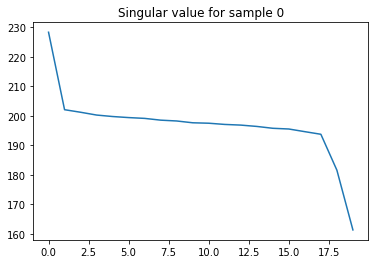

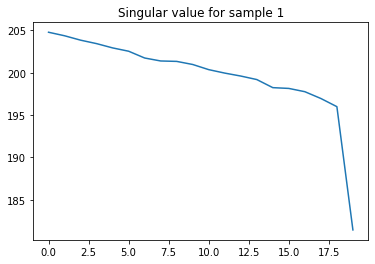

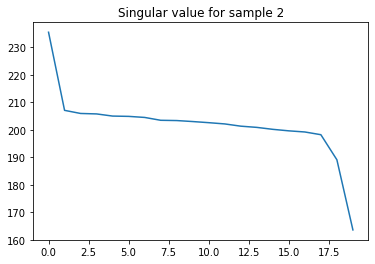

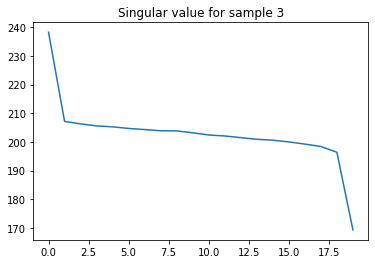

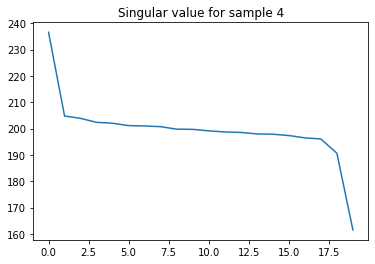

In [22]:
# for the full matrix
for i in range(5):
    data, _ = training_data[i]

    # do the svd
    U, S, VT = np.linalg.svd(data, full_matrices= False)

    # print(data.shape)
    # print(S.shape)

    plt.figure()
    plt.plot(S)
    plt.title(f"Singular value for sample {i}")

print(S)


In [7]:
# define the neural nets
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_nums_layer, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        
        self.LSTM = nn.LSTM(input_dim, hidden_dim, lstm_nums_layer, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input):
        # print(input.shape)
        
        hidden_state, _ = self.LSTM(input)
        
        # print(hidden_state.shape)
        output = self.dropout(hidden_state)
        output = self.hidden_to_output(output)
        
        
        return output
    
    


In [8]:
# train the model

input_dim = training_data[0][0].shape[1]
output_dim = training_data[0][1].shape[1]


# print(output_dim)

# some adjustable hyper-parameters
hidden_dim = 64
num_hidden_layers = 1
batch_size = 5
learning_rate = 1e-3
weight_decay = 1e-5
epoch_num = 200
dropout = 0.2

model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_hidden_layers, dropout)
model = model.double()

train_dataloader = DataLoader(training_data, batch_size = batch_size)


# the chosn loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)



for epoch in range(epoch_num):
    
    for batch, (X, y) in enumerate(train_dataloader):
        

        
        model.zero_grad()
        
        pred = model(X)
        
        # print(X.shape)
        # print(y.shape)
        
        loss = loss_fn(pred, y)
        
        # backpropagation
        
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
    if epoch % 5 == 0:
        print("The loss is {} in epoch {}".format(loss ,epoch))
            

print(f"The training is ended, the final loss is {loss}.")
print("Bye")

The loss is 0.15682949501732796 in epoch 0
The loss is 0.028911932983840836 in epoch 5
The loss is 0.018341095188852644 in epoch 10
The loss is 0.0111381935757081 in epoch 15
The loss is 0.012771628363871745 in epoch 20
The loss is 0.014743590567525338 in epoch 25
The loss is 0.013638395050674634 in epoch 30
The loss is 0.008391932007243225 in epoch 35
The loss is 0.008042588994911967 in epoch 40
The loss is 0.014827931813317865 in epoch 45
The loss is 0.01021627181535407 in epoch 50
The loss is 0.0069980627872048215 in epoch 55
The loss is 0.008635661530716645 in epoch 60
The loss is 0.00996709239752786 in epoch 65
The loss is 0.005413362078770567 in epoch 70
The loss is 0.004087611889938578 in epoch 75
The loss is 0.006933346456165429 in epoch 80
The loss is 0.005718040205848958 in epoch 85
The loss is 0.0068779797359902915 in epoch 90
The loss is 0.01089080668092785 in epoch 95
The loss is 0.004984057905464835 in epoch 100
The loss is 0.005614438170523794 in epoch 105
The loss is 0.

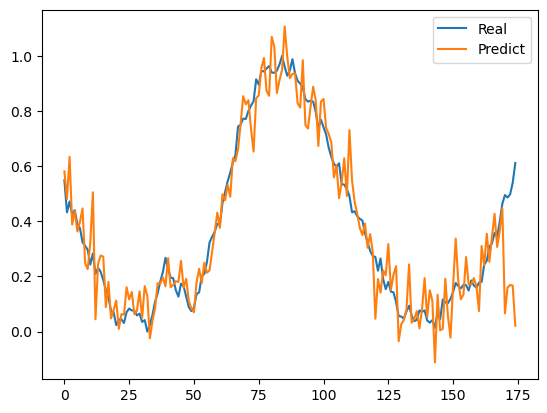

In [11]:
# visualize the training output




X_train = (torch.tensor(training_data.data)).double()
y_train = (torch.tensor(training_data.labels)).double()


plt.figure()
plt.plot(y_train, label = "Real")     
plt.plot(model(X_train).detach().numpy(), label = "Predict")
plt.legend()


0.35771846502605054


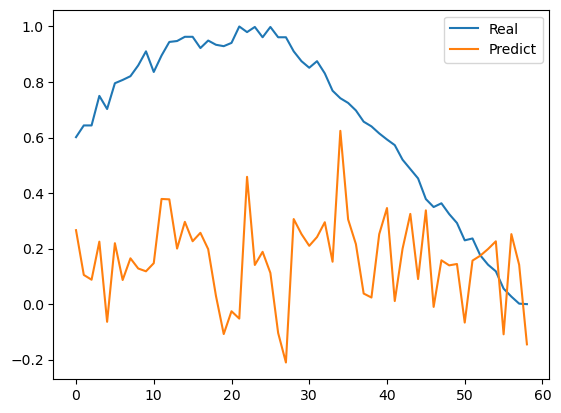

In [12]:
# visualize the test output

import matplotlib.pyplot as plt


X_test = (torch.tensor(testing_data.data)).double()
y_test = (torch.tensor(testing_data.labels)).double()

y_pred = model(X_test)

loss = nn.MSELoss()
print(loss(y_pred, y_test).item())

plt.figure()
plt.plot(y_test, label = "Real")     
plt.plot(y_pred.detach().numpy(), label = "Predict")
plt.legend()